In [1]:
#% reset
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import os
import midi_musical_matrix
import data
import multi_training
from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
from MyFunctions import Input_Kernel, LSTM_TimeWise_Training_Layer, LSTM_NoteWise_Layer, Loss_Function

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2


In [2]:
# Import All Training Data
# Convert Entire Music .MIDI set to list of musical 'pieces'
# During training runs, getPieceBatch will return a tensor for Note_State_Batch, and corresponding Note_State_Expand
# Note_State_Expand will be fed into the graph input, and Note_State_Batch will be used for the loss function.

# Import Midi files to list
Working_Directory = os.getcwd()
Training_Midi_Folder = Working_Directory + "/Midi_Files/Bach_Handpicked"
max_time_steps = 256 # only files atleast this many 16th note steps are saved

practice_batch_size = 15
practice_num_timesteps = 128


training_pieces = multi_training.loadPieces(Training_Midi_Folder, max_time_steps)
print('')
print('Number of training pieces = ', len(training_pieces))

# Generate sample Note State Matrix for dimension measurement and numerical checking purposes
# (Using external code to generate the Note State Matrix but using our own NoteInputForm (as defined in author's code) function
_, sample_state = multi_training.getPieceBatch(training_pieces, practice_batch_size, practice_num_timesteps)
sample_state = np.array(sample_state)
sample_state = np.swapaxes(sample_state, axis1=1, axis2=2)
print('Sample of State Input Batch: shape = ', sample_state.shape)


Skip bad file =  Fugue12
Loaded Fugue8
Loaded Fugue22
Loaded Fugue18
Loaded Fugue5
Skip bad file =  Fugue19
Loaded Fugue4
Loaded Fugue17
Loaded Fugue9 (1)
Loaded Fugue7 (1)
Loaded Fugue3
Loaded Fugue7
Loaded Fugue16
Loaded Fugue3 (1)
Loaded Fugue12 (1)
Loaded Fugue5 (1)
Skip bad file =  Fugue13
Skip bad file =  Fugue15
Loaded Fugue1
Skip bad file =  Fugue6
Loaded Fugue1 (1)
Loaded Fugue20
Skip bad file =  Fugue11
Loaded Fugue8 (1)
Loaded Fugue23
Loaded Fugue2
Loaded Fugue24
Loaded Fugue9

Number of training pieces =  22
Sample of State Input Batch: shape =  (15, 78, 128, 2)


In [3]:
# Beginning of Model Graph:
tf.reset_default_graph()

#input_size = sample_state.shape[-1]
num_notes = sample_state.shape[1]


#place holder inputs
# num_batches and num_time steps are variable lengths.  These values do not affect the model parameters
# Dimension(0) =  num_batches. Dimension(2) = num_time_steps

#final_t_sample_run = np.zeros((batch_size, num_notes, 1, 2)) #start every batch with zero previous input


        
Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
#prev_t_sample = tf.placeholder(dtype=tf.float32, shape=[None, num_notes,1,2])
time_init = tf.placeholder(dtype=tf.int32, shape=())
#Generates expanded tensor input to LSTM-timewise layer
Note_State_Expand = Input_Kernel(Note_State_Batch, Midi_low=24, Midi_high=101, time_init=time_init)

print('Note_State_Batch Placeholder Shape = ', Note_State_Batch.get_shape())
print('Note_State_Expand output Shape = ', Note_State_Expand.get_shape())





Note_State_Batch Placeholder Shape =  (?, 78, ?, 2)
Note_State_Expand output Shape =  (?, 78, ?, 80)


In [4]:
# Check Input Kernel on sample data

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sample_expand = sess.run(Note_State_Expand, feed_dict={Note_State_Batch: sample_state, time_init: 1})



#check MIDI note
print('sample_expand shape = ', sample_expand.shape)
print('MIDI note_0, t_0 = ', sample_expand[0,0,0,[0]]) 
print('MIDI note_1, t_0 = ', sample_expand[0,1,0,[0]])  
print('MIDI note_2, t_0 = ', sample_expand[0,2,0,[0]]) 

print('MIDI note_0, t_0 = ', sample_expand[0,0,0,[0]]) 
print('MIDI note_0, t_1 = ', sample_expand[0,0,1,[0]])  
print('MIDI note_0, t_29 = ', sample_expand[0,0,29,[0]]) 
print('') 

#check pitchclass
print('pitchclass note_0, t_0 = ', sample_expand[0,0,0,1:13]) 
print('pitchclass note_1, t_0 = ', sample_expand[0,1,0,1:13])  
print('pitchclass note_11, t_0 = ', sample_expand[0,11,0,1:13]) 

print('pitchclass note_0, t_0 = ', sample_expand[0,0,0,1:13]) 
print('pitchclass note_0, t_1 = ', sample_expand[0,0,1,1:13])  
print('pitchclass note_0, t_29 = ', sample_expand[0,0,29,1:13]) 
print('') 

#check vicinity
print('sample state local vicinity = ', sample_state[0,33:58,29,:])
print('calculated vicinity note_45, t_29 = ', sample_expand[0,45,29,13:63])
print('')

#check  context
print('calculated context note_45, t_29 = ', sample_expand[0,45,29,63:75])
print('actual all note plays at, t_29 = ', sample_state[0,:,29,0])
print('')

#check beat
print('beat note_0, t_0 = ', sample_expand[0,0,0,75:79]) 
print('beat note_1, t_0 = ', sample_expand[0,1,0,75:79])  
print('beat note_2, t_0 = ', sample_expand[0,2,0,75:79]) 

print('beat note_0, t_0 = ', sample_expand[0,0,0,75:79]) 
print('beat note_0, t_1 = ', sample_expand[0,0,1,75:79])  
print('beat note_0, t_29 = ', sample_expand[0,0,29,75:79]) 
print('')


sample_expand shape =  (15, 78, 128, 80)
MIDI note_0, t_0 =  [ 24.]
MIDI note_1, t_0 =  [ 25.]
MIDI note_2, t_0 =  [ 26.]
MIDI note_0, t_0 =  [ 24.]
MIDI note_0, t_1 =  [ 24.]
MIDI note_0, t_29 =  [ 24.]

pitchclass note_0, t_0 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_1, t_0 =  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_11, t_0 =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
pitchclass note_0, t_0 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_0, t_1 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_0, t_29 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

sample state local vicinity =  [[1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
calculated vicinity note_45, t_29 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0

In [5]:
#lSTM Time Wise Training Graph 
#tf.reset_default_graph()
#Note_State_Expand = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 80])
#Note_State_Expand_val = np.ones((10,78,128,80))

num_t_units=[200, 200]
output_keep_prob = tf.placeholder(dtype=tf.float32, shape=())

# Generate initial state (at t=0) placeholder
timewise_state=[]
for i in range(len(num_t_units)):
    timewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]]) #None = batch_size * num_notes
    timewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]])
    timewise_state.append(LSTMStateTuple(timewise_h, timewise_c))

timewise_state=tuple(timewise_state)


timewise_out, timewise_state_out = LSTM_TimeWise_Training_Layer(input_data=Note_State_Expand, state_init=timewise_state, output_keep_prob=output_keep_prob)


print('Time-wise output shape = ', timewise_out.get_shape())
print(len(timewise_state_out))



Time-wise output shape =  (?, 78, ?, 200)
2


In [6]:
#LSTM Note Wise Graph
#tf.reset_default_graph()
#num_notes=78
#timewise_out = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 50])
#output_keep_prob=1
num_n_units = [100, 100]

# Generate initial state (at n=0) placeholder
notewise_state=[]
for i in range(len(num_n_units)):
    notewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]]) #None = batch_size * num_timesteps
    notewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]])
    notewise_state.append(LSTMStateTuple(notewise_h, notewise_c))

notewise_state=tuple(notewise_state)


y_out, note_gen_out = LSTM_NoteWise_Layer(timewise_out, state_init=notewise_state, output_keep_prob=output_keep_prob)


print('y_out shape = ', y_out.get_shape())
print('generated samples shape = ', note_gen_out.get_shape())




y_out shape =  (?, 78, ?, 2, 2)
generated samples shape =  (?, 78, ?, 2)


In [30]:
# Test for Notewise-LSTM
#num_timesteps=5
#batch_size=7
#timewise_out_val = np.random.randn(batch_size, 78, num_timesteps, 50)*10

#notewise_state_val=[]
#for i in range(len(num_n_units)):
#    c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
#    h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
#    notewise_state_val.append(LSTMStateTuple(h_n, c_n))

#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
#    feed_dict = {timewise_out: timewise_out_val, notewise_state: notewise_state_val}
#    y_out_run, note_gen_out_run = sess.run([y_out, note_gen_out], feed_dict=feed_dict)


In [7]:
# Loss Function and Optimizer

#y_out_val = np.random.randn(1, 78, 128, 2, 2)*5


loss, cross_entropy = Loss_Function(Note_State_Batch, y_out)
optimizer = tf.train.AdadeltaOptimizer(learning_rate = 1).minimize(loss)



#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
#    cross_entropy_out, loss_out = sess.run([cross_entropy, loss], feed_dict={y_out: y_out_val, Note_State_Batch: batch_input_state})
print('cross entropy shape = ', cross_entropy.get_shape())


y_align shape = :  (?, ?, ?, ?, ?)
Note_State_Batch_align shape = :  (?, ?, ?, ?)
cross entropy shape =  (?, ?, ?, ?)


In [32]:
# Training
N_epochs = 2000
loss_hist=[]
restore_model_name = None
save_model_name = 'Practice_fb_artic'
batch_size = 10
num_timesteps = 128
keep_prob=.75

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    # try to restore the pre_trained
    if restore_model_name is not None:
        print("Load the model from: {}".format(restore_model_name))
        saver.restore(sess, 'model/{}'.format(restore_model_name))
    
    # Initial States
    timewise_state_val=[]
    for i in range(len(num_t_units)):
        c_t = np.zeros((batch_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
        h_t = np.zeros((batch_size*num_notes, num_t_units[i]))
        timewise_state_val.append(LSTMStateTuple(h_t, c_t))
        
    notewise_state_val=[]
    for i in range(len(num_n_units)):
        c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
        h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
        notewise_state_val.append(LSTMStateTuple(h_n, c_n))
    
  

    # Training Loop
    for epoch in range(N_epochs+1):
        
        #Generate random batch of training data
        
        if (epoch % 100 == 0):         
            print('Obtaining new batch of pieces')
            _, batch_input_state = multi_training.getPieceBatch(training_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state = np.array(batch_input_state)
            batch_input_state = np.swapaxes(batch_input_state, axis1=1, axis2=2)           
            #print('sum = ',sum(sum(sum(sum(batch_input_state)))) )
        
        """
        print('Note_State_Batch shape = ', Note_State_Batch.get_shape())
        print('batch_input_state shape = ', batch_input_state.shape)
        print('')
        print('timewise_state shape = ', Note_State_Batch.get_shape())
        print('timewise_state_val shape = ', batch_input_state.shape)      
        print('')
        print('notewise_state shape = ', Note_State_Batch.get_shape())
        print('notewise_state_val shape = ', batch_input_state.shape)
        ('')
        print('time_init shape = ', time_init.get_shape())
        """
    
        feed_dict = {Note_State_Batch: batch_input_state, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
        #try:
        loss_run, _, note_gen_out_run = sess.run([loss, optimizer, note_gen_out], feed_dict=feed_dict)
        #except:
        #   save_path = saver.save(sess, 'model/{}'.format(save_model_name))
        #    print("Model saved in file: %s" % save_path)
        
        print('epoch = ', epoch, '; loss = ', loss_run)
        loss_hist.append(loss_run)
        
        if (epoch % 500 ==0):
            error = sum(sum(sum(abs(batch_input_state[:,:,1:,:] - note_gen_out_run[:,:,:-1,:]))))
            num_1 = sum(sum(sum(abs(batch_input_state[:,:,1:,:]))))
            print('error = ', error)
            print('num_1 = ', num_1)
        if (epoch % 100 == 0) & (epoch > 0):
            save_path = saver.save(sess, 'model/{}'.format(save_model_name))
            print("Model saved in file: %s" % save_path)
            
    #save_path = saver.save(sess, 'model/{}'.format(save_model_name))
    #print(" Final Model saved in file: %s" % save_path)


Obtaining new batch of pieces
epoch =  0 ; loss =  0.691344
error =  [48650 25362]
num_1 =  [3321 2010]
epoch =  1 ; loss =  0.666124
epoch =  2 ; loss =  0.648802
epoch =  3 ; loss =  0.633244
epoch =  4 ; loss =  0.617533
epoch =  5 ; loss =  0.601373
epoch =  6 ; loss =  0.584985
epoch =  7 ; loss =  0.567797
epoch =  8 ; loss =  0.550634
epoch =  9 ; loss =  0.533605
epoch =  10 ; loss =  0.515145
epoch =  11 ; loss =  0.497537
epoch =  12 ; loss =  0.481356
epoch =  13 ; loss =  0.463749
epoch =  14 ; loss =  0.447935
epoch =  15 ; loss =  0.427932
epoch =  16 ; loss =  0.410303
epoch =  17 ; loss =  0.392965
epoch =  18 ; loss =  0.376925
epoch =  19 ; loss =  0.361242
epoch =  20 ; loss =  0.351831
epoch =  21 ; loss =  0.337302
epoch =  22 ; loss =  0.328569
epoch =  23 ; loss =  0.308442
epoch =  24 ; loss =  0.296727
epoch =  25 ; loss =  0.287219
epoch =  26 ; loss =  0.284803
epoch =  27 ; loss =  0.267011
epoch =  28 ; loss =  0.259147
epoch =  29 ; loss =  0.247412
epoch 

epoch =  254 ; loss =  0.117843
epoch =  255 ; loss =  0.118175
epoch =  256 ; loss =  0.118568
epoch =  257 ; loss =  0.118104
epoch =  258 ; loss =  0.118419
epoch =  259 ; loss =  0.118002
epoch =  260 ; loss =  0.117793
epoch =  261 ; loss =  0.118079
epoch =  262 ; loss =  0.1179
epoch =  263 ; loss =  0.11785
epoch =  264 ; loss =  0.117914
epoch =  265 ; loss =  0.117667
epoch =  266 ; loss =  0.117218
epoch =  267 ; loss =  0.117135
epoch =  268 ; loss =  0.117553
epoch =  269 ; loss =  0.117744
epoch =  270 ; loss =  0.117323
epoch =  271 ; loss =  0.117235
epoch =  272 ; loss =  0.116954
epoch =  273 ; loss =  0.117908
epoch =  274 ; loss =  0.117561
epoch =  275 ; loss =  0.117498
epoch =  276 ; loss =  0.11719
epoch =  277 ; loss =  0.117567
epoch =  278 ; loss =  0.116746
epoch =  279 ; loss =  0.116881
epoch =  280 ; loss =  0.117161
epoch =  281 ; loss =  0.117077
epoch =  282 ; loss =  0.11696
epoch =  283 ; loss =  0.116771
epoch =  284 ; loss =  0.117785
epoch =  285 

epoch =  503 ; loss =  0.113771
epoch =  504 ; loss =  0.113604
epoch =  505 ; loss =  0.113153
epoch =  506 ; loss =  0.113291
epoch =  507 ; loss =  0.11255
epoch =  508 ; loss =  0.112736
epoch =  509 ; loss =  0.112811
epoch =  510 ; loss =  0.112618
epoch =  511 ; loss =  0.112766
epoch =  512 ; loss =  0.112438
epoch =  513 ; loss =  0.112638
epoch =  514 ; loss =  0.112339
epoch =  515 ; loss =  0.112535
epoch =  516 ; loss =  0.112522
epoch =  517 ; loss =  0.112419
epoch =  518 ; loss =  0.11242
epoch =  519 ; loss =  0.111976
epoch =  520 ; loss =  0.111768
epoch =  521 ; loss =  0.112211
epoch =  522 ; loss =  0.111986
epoch =  523 ; loss =  0.112348
epoch =  524 ; loss =  0.112497
epoch =  525 ; loss =  0.111819
epoch =  526 ; loss =  0.111396
epoch =  527 ; loss =  0.111241
epoch =  528 ; loss =  0.111784
epoch =  529 ; loss =  0.11165
epoch =  530 ; loss =  0.11133
epoch =  531 ; loss =  0.111938
epoch =  532 ; loss =  0.1116
epoch =  533 ; loss =  0.111483
epoch =  534 ;

epoch =  756 ; loss =  0.114378
epoch =  757 ; loss =  0.114277
epoch =  758 ; loss =  0.113927
epoch =  759 ; loss =  0.114461
epoch =  760 ; loss =  0.114152
epoch =  761 ; loss =  0.114424
epoch =  762 ; loss =  0.114193
epoch =  763 ; loss =  0.113666
epoch =  764 ; loss =  0.114063
epoch =  765 ; loss =  0.114401
epoch =  766 ; loss =  0.113634
epoch =  767 ; loss =  0.114222
epoch =  768 ; loss =  0.114138
epoch =  769 ; loss =  0.114313
epoch =  770 ; loss =  0.114219
epoch =  771 ; loss =  0.114332
epoch =  772 ; loss =  0.114262
epoch =  773 ; loss =  0.114356
epoch =  774 ; loss =  0.11434
epoch =  775 ; loss =  0.114052
epoch =  776 ; loss =  0.113682
epoch =  777 ; loss =  0.113869
epoch =  778 ; loss =  0.113773
epoch =  779 ; loss =  0.113745
epoch =  780 ; loss =  0.113903
epoch =  781 ; loss =  0.113919
epoch =  782 ; loss =  0.114242
epoch =  783 ; loss =  0.113926
epoch =  784 ; loss =  0.11387
epoch =  785 ; loss =  0.113637
epoch =  786 ; loss =  0.114367
epoch =  7

epoch =  1005 ; loss =  0.111417
epoch =  1006 ; loss =  0.111282
epoch =  1007 ; loss =  0.110964
epoch =  1008 ; loss =  0.111164
epoch =  1009 ; loss =  0.110855
epoch =  1010 ; loss =  0.111221
epoch =  1011 ; loss =  0.111915
epoch =  1012 ; loss =  0.111253
epoch =  1013 ; loss =  0.111409
epoch =  1014 ; loss =  0.110626
epoch =  1015 ; loss =  0.110724
epoch =  1016 ; loss =  0.110599
epoch =  1017 ; loss =  0.110783
epoch =  1018 ; loss =  0.110701
epoch =  1019 ; loss =  0.110422
epoch =  1020 ; loss =  0.110721
epoch =  1021 ; loss =  0.11053
epoch =  1022 ; loss =  0.110357
epoch =  1023 ; loss =  0.110143
epoch =  1024 ; loss =  0.110312
epoch =  1025 ; loss =  0.110411
epoch =  1026 ; loss =  0.110903
epoch =  1027 ; loss =  0.110796
epoch =  1028 ; loss =  0.110119
epoch =  1029 ; loss =  0.110634
epoch =  1030 ; loss =  0.110521
epoch =  1031 ; loss =  0.110393
epoch =  1032 ; loss =  0.110306
epoch =  1033 ; loss =  0.110105
epoch =  1034 ; loss =  0.110084
epoch =  10

epoch =  1250 ; loss =  0.117151
epoch =  1251 ; loss =  0.117369
epoch =  1252 ; loss =  0.117326
epoch =  1253 ; loss =  0.117186
epoch =  1254 ; loss =  0.117619
epoch =  1255 ; loss =  0.117685
epoch =  1256 ; loss =  0.117321
epoch =  1257 ; loss =  0.118132
epoch =  1258 ; loss =  0.117201
epoch =  1259 ; loss =  0.118003
epoch =  1260 ; loss =  0.117932
epoch =  1261 ; loss =  0.118023
epoch =  1262 ; loss =  0.117475
epoch =  1263 ; loss =  0.11752
epoch =  1264 ; loss =  0.117097
epoch =  1265 ; loss =  0.117336
epoch =  1266 ; loss =  0.117341
epoch =  1267 ; loss =  0.117298
epoch =  1268 ; loss =  0.117249
epoch =  1269 ; loss =  0.117533
epoch =  1270 ; loss =  0.117385
epoch =  1271 ; loss =  0.117286
epoch =  1272 ; loss =  0.117462
epoch =  1273 ; loss =  0.117498
epoch =  1274 ; loss =  0.117212
epoch =  1275 ; loss =  0.117346
epoch =  1276 ; loss =  0.117078
epoch =  1277 ; loss =  0.117735
epoch =  1278 ; loss =  0.117494
epoch =  1279 ; loss =  0.117637
epoch =  12

epoch =  1495 ; loss =  0.11168
epoch =  1496 ; loss =  0.110947
epoch =  1497 ; loss =  0.111057
epoch =  1498 ; loss =  0.111292
epoch =  1499 ; loss =  0.111288
Obtaining new batch of pieces
epoch =  1500 ; loss =  0.114013
error =  [7059 2124]
num_1 =  [3646 1930]
Model saved in file: model/Practice_fb_artic
epoch =  1501 ; loss =  0.11331
epoch =  1502 ; loss =  0.112421
epoch =  1503 ; loss =  0.112639
epoch =  1504 ; loss =  0.112531
epoch =  1505 ; loss =  0.113091
epoch =  1506 ; loss =  0.112666
epoch =  1507 ; loss =  0.112019
epoch =  1508 ; loss =  0.112231
epoch =  1509 ; loss =  0.112675
epoch =  1510 ; loss =  0.112241
epoch =  1511 ; loss =  0.1122
epoch =  1512 ; loss =  0.11169
epoch =  1513 ; loss =  0.112221
epoch =  1514 ; loss =  0.112605
epoch =  1515 ; loss =  0.11226
epoch =  1516 ; loss =  0.1117
epoch =  1517 ; loss =  0.111993
epoch =  1518 ; loss =  0.112231
epoch =  1519 ; loss =  0.111656
epoch =  1520 ; loss =  0.111505
epoch =  1521 ; loss =  0.111402


epoch =  1737 ; loss =  0.104238
epoch =  1738 ; loss =  0.10406
epoch =  1739 ; loss =  0.104116
epoch =  1740 ; loss =  0.10398
epoch =  1741 ; loss =  0.104004
epoch =  1742 ; loss =  0.103906
epoch =  1743 ; loss =  0.103956
epoch =  1744 ; loss =  0.103868
epoch =  1745 ; loss =  0.10411
epoch =  1746 ; loss =  0.103954
epoch =  1747 ; loss =  0.103957
epoch =  1748 ; loss =  0.103829
epoch =  1749 ; loss =  0.104418
epoch =  1750 ; loss =  0.103588
epoch =  1751 ; loss =  0.103512
epoch =  1752 ; loss =  0.103615
epoch =  1753 ; loss =  0.103391
epoch =  1754 ; loss =  0.103975
epoch =  1755 ; loss =  0.103921
epoch =  1756 ; loss =  0.103644
epoch =  1757 ; loss =  0.103433
epoch =  1758 ; loss =  0.103284
epoch =  1759 ; loss =  0.103259
epoch =  1760 ; loss =  0.103569
epoch =  1761 ; loss =  0.103274
epoch =  1762 ; loss =  0.103768
epoch =  1763 ; loss =  0.103722
epoch =  1764 ; loss =  0.103381
epoch =  1765 ; loss =  0.103284
epoch =  1766 ; loss =  0.103001
epoch =  1767

epoch =  1982 ; loss =  0.105712
epoch =  1983 ; loss =  0.105881
epoch =  1984 ; loss =  0.105827
epoch =  1985 ; loss =  0.105462
epoch =  1986 ; loss =  0.105636
epoch =  1987 ; loss =  0.106039
epoch =  1988 ; loss =  0.105469
epoch =  1989 ; loss =  0.105761
epoch =  1990 ; loss =  0.10572
epoch =  1991 ; loss =  0.105656
epoch =  1992 ; loss =  0.105911
epoch =  1993 ; loss =  0.105676
epoch =  1994 ; loss =  0.105473
epoch =  1995 ; loss =  0.105358
epoch =  1996 ; loss =  0.105527
epoch =  1997 ; loss =  0.105504
epoch =  1998 ; loss =  0.106082
epoch =  1999 ; loss =  0.105676
Obtaining new batch of pieces
epoch =  2000 ; loss =  0.104154
error =  [6653 1868]
num_1 =  [3382 1719]
Model saved in file: model/Practice_fb_artic


In [27]:


#print(square_error/mag)
#print('Actual input = ', batch_input_state[:,:,1,:])
#print('Output predicting this input = ', note_gen_out_run[:,:,0,:])
error = sum(sum(sum(abs(batch_input_state[:,:,1:,:] - note_gen_out_run[:,:,:-1,:]))))
num_1 = sum(sum(sum(abs(batch_input_state[:,:,1:,:]))))
print('error = ', error)
print('num_1 = ', num_1)
#for v in range(len(tf.trainable_variables())):
#    print(tf.trainable_variables()[v])

error =  [3520 1723]
num_1 =  [3824 1511]


In [20]:
(1000 % 100 == 0) & (1000 > 0)


True

2001

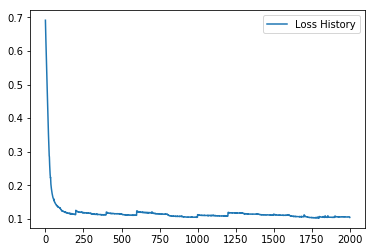

In [33]:
plt.plot(loss_hist, label="Loss History")
plt.legend()
plt.show
len(loss_hist)

In [34]:
# Music Generation
# input = initial note vector
# for t = 1:Tsong
#    input --> input kernel
#    run through 1 'call' of Model LSTM with present parameters / states
#    run through note-wise LSTM block as normally done to produce vector of generated samples
#    input = generated samples
#    music_sequence.append(input)

# store batch of music sequences in .MIDI files


#Load Model
restore_model_name = 'Practice_fb_artic'

#Length of generated music
T_gen = 16*16
batch_gen_size = 5
keep_prob = 1

# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)
notes_gen_initial = np.zeros((batch_gen_size, num_notes, 1,2))

# Initial States
notes_gen = notes_gen_initial
    
timewise_state_val=[]
for i in range(len(num_t_units)):
    c = np.zeros((batch_gen_size*num_notes, num_t_units[i])) #start first time step with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*num_notes, num_t_units[i]))
    timewise_state_val.append(LSTMStateTuple(h, c))
        
notewise_state_val=[]
for i in range(len(num_n_units)):
    c = np.zeros((batch_gen_size*1, num_n_units[i])) #start every batch with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*1, num_n_units[i]))
    notewise_state_val.append(LSTMStateTuple(h, c))
        
notes_gen_arr=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    print("Load the model from: {}".format(restore_model_name))
    saver.restore(sess, 'model/{}'.format(restore_model_name))
    

    for t in range(T_gen):
        feed_dict = {Note_State_Batch: notes_gen, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: t % 16, output_keep_prob: keep_prob}    
        timewise_state_val, notes_gen = np.squeeze(sess.run([timewise_state_out, note_gen_out], feed_dict = feed_dict), axis=2)
        #print('notes_gen shape = ', notes_gen.shape)
        #notes_gen = np.squeeze(notes_gen, axis=2)
        notes_gen_arr.append(np.squeeze(notes_gen))
        
        
        
        if t % 50 == 0:
            print('Timestep = ', t)
    
notes_gen_out = np.stack(notes_gen_arr, axis=2)
print(notes_gen_out.shape)
        


Load the model from: Practice_fb_artic
INFO:tensorflow:Restoring parameters from model/Practice_fb_artic
Timestep =  0
Timestep =  50
Timestep =  100
Timestep =  150
Timestep =  200
Timestep =  250
(5, 78, 256, 2)


In [35]:
# Save Generate Notes to .MIDI file

notes_gen_out = np.swapaxes(notes_gen_out, axis1=1, axis2=2)
print(notes_gen_out.shape)
#_, notes_gen_out = Utils.multi_training.getPieceBatch(training_pieces)


#print(test_batch.shape)
for iter in range(4):
    file = 'Generated_Midi_Files/Practice_fb_artic' + str(iter)
    midi_out = midi_musical_matrix.noteStateMatrixToMidi(notes_gen_out[iter,:,:,:], name=file)

(5, 256, 78, 2)


Items to Experiment with:
- different T length or variable length T from batch-to-batch for training
- categorize music, either through (unsupervised) clustering or (supervised) labeled music folders.  For clustering, the model would possibly find 'k' 'centroids' in an unsupervised manner each with its own music distribution, so during the music generation stage, 1 of these centroids would be selected for a piece of music.  
- use encoder to reduce dimensionality of each note vector (vector of 79 notes in 1 time step), similiar to encoding the words from the tweets in homework 3 (i.e. there are restricted combinations of notes that can be played simultaneously)
- more advanced sampling/exploring for training/music generation.  This may help prevent the algorithm from getting 'stuck' on a chord, or 